In [1]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

In [2]:
#data path
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrBandNearby'
dpathalt='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_R'

#file name
fname='F0588_FO_IMA_07018911_FORF253_CAL_0114-0124_Field_11.fits'

#Name of field
field='Field11'

#wavelength of data
wavelength=25.2

In [3]:
#change directory to data location
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

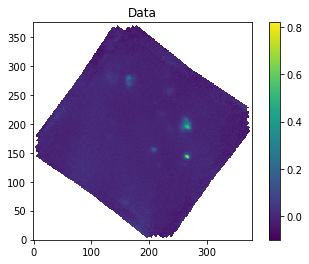

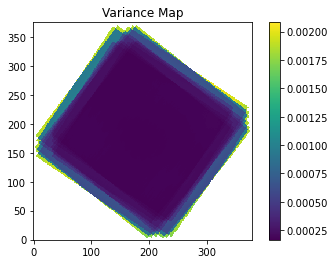

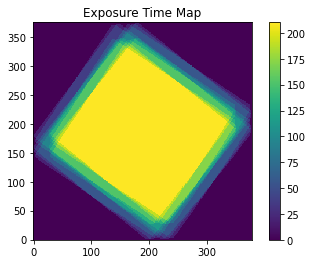

In [4]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

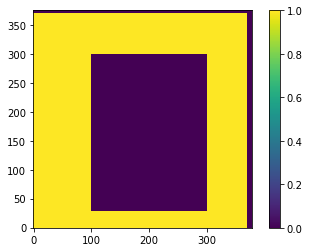

In [5]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.2,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[0:300,0:100]=1
mask2[300:370,0:370]=1
mask2[0:300,300:370]=1
mask2[0:30,0:370]=1
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [6]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

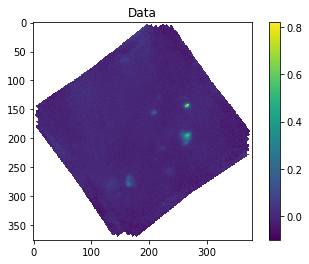

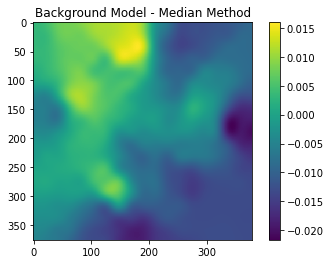

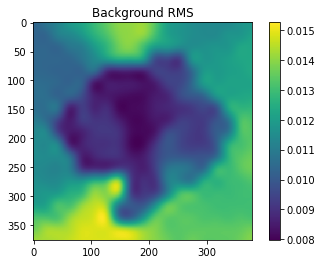

In [7]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [8]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

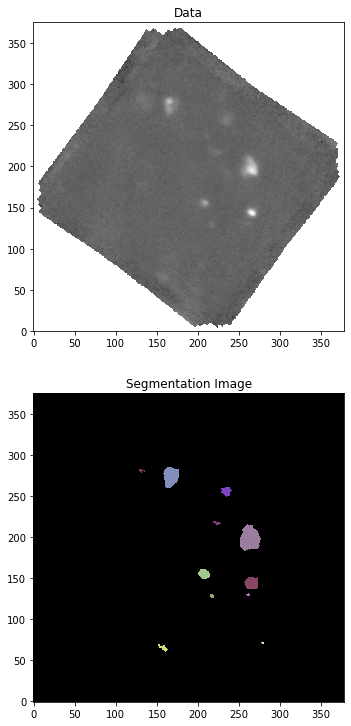

In [9]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [10]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,158.27462358787824,65.07841962339123,"266.8609468090082,-28.412482404950453",0.0024865805224317324,0.01344838396323351,0.6455224302352085,48.0,3.3077889752807215,1.3166437334782324,-29.068902465733533,0.20599246995224363,0.4123069947429693,0.4622536757230209,0.9173665638233105,0.6019565506392399,2.5122885494182987,5.928120587196158,8.490945436174862,nan,3.0087245988978317,2.1996626707970486,nan
3,278.7389213087709,71.55255125284027,"266.83172847693214,-28.411100455365567",-0.00011639078539074459,-0.00936655795674954,-0.06556590569724678,7.0,1.034290607808762,0.470932809751189,-9.978434125540332,1.042108180537634,1.2199291461860322,4.40170288652886,0.8903280523467559,0.5446803768730892,2.196259394955334,1.8923252218297166,1.2607751880868743,nan,3.224000476850742,0.32182342854847545,nan
4,216.9839326835924,128.89436277905955,"266.84670732236384,-28.398868727378034",-5.568989780271857e-05,-0.004244606627923535,-0.10611516569808838,25.0,1.7977811700396433,1.0799836039398731,-60.71491817341816,0.7262526984734857,0.4675634345499375,0.4405164540643116,0.7994509252401655,0.39926859734766373,1.6646374662366936,3.492120208889248,1.6519594870664407,nan,1.7767815870169286,0.8505805112148893,nan
5,261.3671641025265,130.1987883087519,"266.8359436052319,-28.398589760703242",0.0050200067053512,-0.003455297792319538,-0.05182946688479307,15.0,1.3667559029878051,0.8691814559749101,6.737605989682922,0.5461768951858714,-0.1837032203072502,1.3128168718353626,0.7717344588185465,0.364055092738337,1.5724632567716195,2.6970133944355315,2.8711932994334077,nan,3.2420760049806563,0.5690717942172897,nan
6,265.56472987147123,143.6208772819209,"266.834926030287,-28.39572627300481",0.003770392684631507,5.466978265913949e-05,0.01169933348905585,214.0,3.0493469611394093,2.6792433675602405,-21.331838133322773,0.11174727214884744,0.021526154457193934,0.13510463631363015,0.4775058445351508,0.1213714274878307,1.1381373555162295,6.7589615707728825,38.710953312454976,nan,1.525796663525305,36.98288224201638,nan
7,207.9133585897782,155.32043967951387,"266.8489071675111,-28.39323120131354",-0.006426676092650753,-0.0011051638284400591,-0.14698678918252786,133.0,2.952946822262149,2.385370830108903,-26.73826590365779,0.12704167279976636,0.04907410714898895,0.1633857178735144,0.5894657670006075,0.19220664181092362,1.237940359205002,6.320814468267801,12.093224053765486,nan,1.572770282611008,10.355906673353864,nan
8,264.1374007767044,197.7114895948647,"266.83527378672403,-28.384186980784133",-0.007823184939545223,-0.00407912432892458,-2.47602846765722,607.0,6.103876589669358,4.898756737606068,-81.85712871932434,0.041372928126559516,0.00415876908459226,0.027137898621124323,0.596564898270643,0.19743516015755003,1.2460052451292385,13.03208633676525,95.4184780884988,nan,1.449215760373078,88.73949140602554,nan
12,223.1827804281998,216.98181040181683,"266.8452048538594,-28.380076693443684",-0.007455255489695025,-0.006803136446033029,-0.20409409338099085,30.0,2.3118842299748508,1.0352891928462786,-16.277509275313218,0.2456965191378331,0.40137126986799015,0.8743901645965646,0.8941278051569258,0.5521881332018339,2.2330806174252444,4.217900264658947,3.276356586223004,nan,2.89584529740604,1.1080171857909593,nan


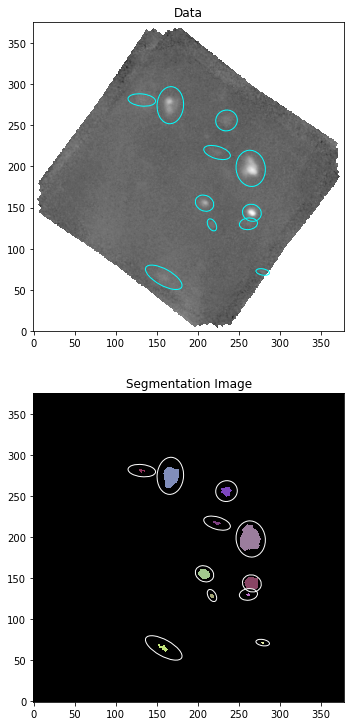

In [11]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

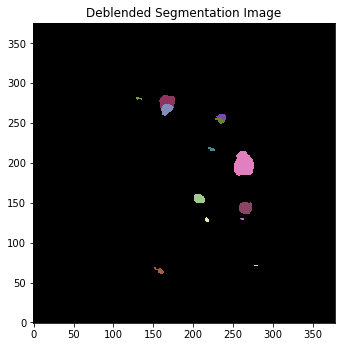

In [12]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [13]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,158.27462358787824,65.07841962339123,"266.8609468090082,-28.412482404950453",0.0024865805224317324,0.01344838396323351,0.6455224302352085,48.0,3.3077889752807215,1.3166437334782324,-29.068902465733533,0.20599246995224363,0.4123069947429693,0.4622536757230209,0.9173665638233105,0.6019565506392399,2.5122885494182987,5.928120587196158,8.490945436174862,nan,3.0087245988978317,2.1996626707970486,nan
2,278.7389213087709,71.55255125284027,"266.83172847693214,-28.411100455365567",-0.00011639078539074459,-0.00936655795674954,-0.06556590569724678,7.0,1.034290607808762,0.470932809751189,-9.978434125540332,1.042108180537634,1.2199291461860322,4.40170288652886,0.8903280523467559,0.5446803768730892,2.196259394955334,1.8923252218297166,1.2607751880868743,nan,3.224000476850742,0.32182342854847545,nan
3,216.9839326835924,128.89436277905955,"266.84670732236384,-28.398868727378034",-5.568989780271857e-05,-0.004244606627923535,-0.10611516569808838,25.0,1.7977811700396433,1.0799836039398731,-60.71491817341816,0.7262526984734857,0.4675634345499375,0.4405164540643116,0.7994509252401655,0.39926859734766373,1.6646374662366936,3.492120208889248,1.6519594870664407,nan,1.7767815870169286,0.8505805112148893,nan
4,261.3671641025265,130.1987883087519,"266.8359436052319,-28.398589760703242",0.0050200067053512,-0.003455297792319538,-0.05182946688479307,15.0,1.3667559029878051,0.8691814559749101,6.737605989682922,0.5461768951858714,-0.1837032203072502,1.3128168718353626,0.7717344588185465,0.364055092738337,1.5724632567716195,2.6970133944355315,2.8711932994334077,nan,3.2420760049806563,0.5690717942172897,nan
5,265.56472987147123,143.6208772819209,"266.834926030287,-28.39572627300481",0.003770392684631507,5.466978265913949e-05,0.01169933348905585,214.0,3.0493469611394093,2.6792433675602405,-21.331838133322773,0.11174727214884744,0.021526154457193934,0.13510463631363015,0.4775058445351508,0.1213714274878307,1.1381373555162295,6.7589615707728825,38.710953312454976,nan,1.525796663525305,36.98288224201638,nan
6,207.9133585897782,155.32043967951387,"266.8489071675111,-28.39323120131354",-0.006426676092650753,-0.0011051638284400591,-0.14698678918252786,133.0,2.952946822262149,2.385370830108903,-26.73826590365779,0.12704167279976636,0.04907410714898895,0.1633857178735144,0.5894657670006075,0.19220664181092362,1.237940359205002,6.320814468267801,12.093224053765486,nan,1.572770282611008,10.355906673353864,nan
7,264.1374007767044,197.7114895948647,"266.83527378672403,-28.384186980784133",-0.007823184939545223,-0.00407912432892458,-2.47602846765722,607.0,6.103876589669358,4.898756737606068,-81.85712871932434,0.041372928126559516,0.00415876908459226,0.027137898621124323,0.596564898270643,0.19743516015755003,1.2460052451292385,13.03208633676525,95.4184780884988,nan,1.449215760373078,88.73949140602554,nan
8,223.1827804281998,216.98181040181683,"266.8452048538594,-28.380076693443684",-0.007455255489695025,-0.006803136446033029,-0.20409409338099085,30.0,2.3118842299748508,1.0352891928462786,-16.277509275313218,0.2456965191378331,0.40137126986799015,0.8743901645965646,0.8941278051569258,0.5521881332018339,2.2330806174252444,4.217900264658947,3.276356586223004,nan,2.89584529740604,1.1080171857909593,nan


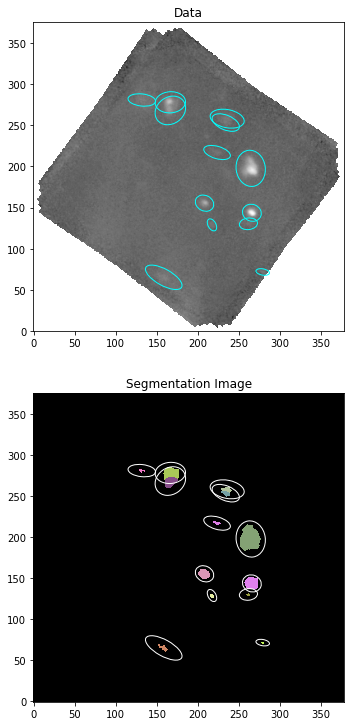

In [14]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [15]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [16]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [17]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,158.27462358787824,65.07841962339123,"266.8609468090082,-28.412482404950453",0.0024865805224317324,0.01344838396323351,0.6455224302352085,48.0,3.3077889752807215,1.3166437334782324,-29.068902465733533,0.20599246995224363,0.4123069947429693,0.4622536757230209,0.9173665638233105,0.6019565506392399,2.5122885494182987,5.928120587196158,8.490945436174862,0.47992337498829357,3.0087245988978317,2.1996626707970486,0.11345766,0.013434433152908988,0.013577648926821326,0.0009499297157522424,2.514623187184675
2,278.7389213087709,71.55255125284027,"266.83172847693214,-28.411100455365567",-0.00011639078539074459,-0.00936655795674954,-0.06556590569724678,7.0,1.034290607808762,0.470932809751189,-9.978434125540332,1.042108180537634,1.2199291461860322,4.40170288652886,0.8903280523467559,0.5446803768730892,2.196259394955334,1.8923252218297166,1.2607751880868743,0.26656447439789666,3.224000476850742,0.32182342854847545,0.06593666,-0.009387274203715204,-0.00939183720670379,9.820042081901276e-05,1.2532975124905006
3,216.9839326835924,128.89436277905955,"266.84670732236384,-28.398868727378034",-5.568989780271857e-05,-0.004244606627923535,-0.10611516569808838,25.0,1.7977811700396433,1.0799836039398731,-60.71491817341816,0.7262526984734857,0.4675634345499375,0.4405164540643116,0.7994509252401655,0.39926859734766373,1.6646374662366936,3.492120208889248,1.6519594870664407,0.14598536661559247,1.7767815870169286,0.8505805112148893,0.06649592,-0.0042191621800663015,-0.004219725847546267,0.0002484759853460247,3.298510991907129
4,261.3671641025265,130.1987883087519,"266.8359436052319,-28.398589760703242",0.0050200067053512,-0.003455297792319538,-0.05182946688479307,15.0,1.3667559029878051,0.8691814559749101,6.737605989682922,0.5461768951858714,-0.1837032203072502,1.3128168718353626,0.7717344588185465,0.364055092738337,1.5724632567716195,2.6970133944355315,2.8711932994334077,0.20875200166597735,3.2420760049806563,0.5690717942172897,0.051510442,-0.0033861773585328356,-0.00339122499308352,0.0005555779751921032,2.5073757546534825
5,265.56472987147123,143.6208772819209,"266.834926030287,-28.39572627300481",0.003770392684631507,5.466978265913949e-05,0.01169933348905585,214.0,3.0493469611394093,2.6792433675602405,-21.331838133322773,0.11174727214884744,0.021526154457193934,0.13510463631363015,0.4775058445351508,0.1213714274878307,1.1381373555162295,6.7589615707728825,38.710953312454976,0.2571382967792095,1.525796663525305,36.98288224201638,0.19468468,-0.00016363739129492092,-6.692489986840975e-05,0.0014213244193258714,83.81753048398316
6,207.9133585897782,155.32043967951387,"266.8489071675111,-28.39323120131354",-0.006426676092650753,-0.0011051638284400591,-0.14698678918252786,133.0,2.952946822262149,2.385370830108903,-26.73826590365779,0.12704167279976636,0.04907410714898895,0.1633857178735144,0.5894657670006075,0.19220664181092362,1.237940359205002,6.320814468267801,12.093224053765486,0.2412157223092655,1.572770282611008,10.355906673353864,0.1505124,-0.0011158346110425048,-0.0011132298710436698,0.00027037668181991483,26.69328303652462
7,264.1374007767044,197.7114895948647,"266.83527378672403,-28.384186980784133",-0.007823184939545223,-0.00407912432892458,-2.47602846765722,607.0,6.103876589669358,4.898756737606068,-81.85712871932434,0.041372928126559516,0.00415876908459226,0.027137898621124323,0.596564898270643,0.19743516015755003,1.2460052451292385,13.03208633676525,9

In [18]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [19]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,158.27462358783646,65.07841962339378,"266.8609468090082,-28.412482404950453",0.9887937677567076,0.07576963516006971,3.128296623284699,0.1526493292065985,5.451971994983615,0.2313949035967964,6.672809128132846,0.3188058474807559,6.925740867572229,0.4135951234064829
2,278.7389213086773,71.55255125291171,"266.83172847693214,-28.411100455365567",0.708049063706747,0.11498925794695404,1.2617840170484447,0.24287705756534647,nan,nan,nan,nan,nan,nan
3,216.98393268350947,128.8943627789915,"266.84670732236384,-28.398868727378034",0.7088360408750459,0.061374617703644295,1.7268963706121618,0.1228292331495878,1.6268695662459856,0.1842894501692138,1.1379337411941226,0.24575261019199912,0.7469803915419491,0.307155881959894
4,261.36716410260584,130.19878830871642,"266.8359436052319,-28.398589760703242",0.7023919148846808,0.06138835429612664,1.6247912647724463,0.12287403327665299,2.7142438714023998,0.18456308502490704,5.58312932151901,0.24616122707526514,15.1259065979482,0.3078424797716015
5,265.56472987149033,143.6208772819432,"266.834926030287,-28.39572627300481",13.031744285079593,0.0615002050182583,29.202749338773778,0.12286851868629502,36.226039184262596,0.1842992440047521,38.61542636233477,0.2456848277637936,40.02144095000108,0.3070879516136866
6,207.91335858983115,155.32043967954496,"266.8489071675111,-28.39323120131354",3.4304989565118227,0.06031806312469816,8.686234842814093,0.12057408188470091,11.296348888818628,0.18073520884089808,12.178659470625448,0.24083468275624118,12.588452052397313,0.30097158300329446
7,264.1374007766362,197.71148959487283,"266.83527378672403,-28.384186980784133",8.76269206562731,0.061721804549882485,30.17733364494083,0.12339138521699955,54.02941201556699,0.18505605595682129,72.65491369078224,0.24674890535565375,84.44472407598971,0.30844797101924715
8,223.1827804280639,216.9818104017843,"266.8452048538594,-28.380076693443684",0.783922432053277,0.06128525736419265,2.1035429563199948,0.12271734648071046,2.8824494555028295,0.18416409413885154,3.257011621372481,0.2456393098342836,3.3473867114843063,0.3070765779171404


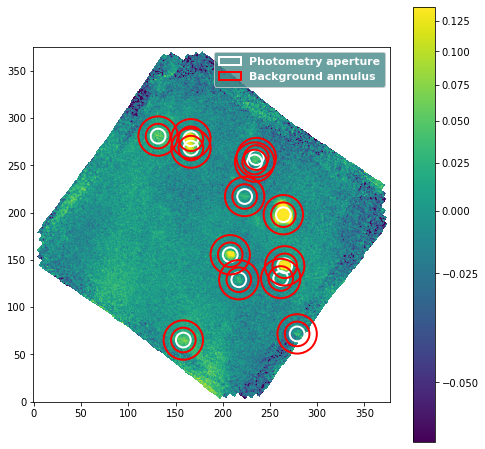

In [20]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [21]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [22]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-22-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,158.27462358783646,65.07841962339378,"266.8609468090082,-28.412482404950453",5.451971994983615,0.2313949035967964,4.396147090436945e-05,-0.0008022011539101605,5.443542488657728,0.2313949035967964,4.396147090436944e-05,10.019512919812733
2,278.7389213086773,71.55255125291171,"266.83172847693214,-28.411100455365567",nan,nan,-0.0023803266591525193,-0.0036027509152585253,nan,nan,0.0,nan
3,216.98393268350947,128.8943627789915,"266.84670732236384,-28.398868727378034",1.6268695662459856,0.1842894501692138,-0.0009334001240338353,-0.0018098038139636081,1.8058467953574158,0.1842894501692138,0.0,3.7917731807940003
4,261.36716410260584,130.19878830871642,"266.8359436052319,-28.398589760703242",2.7142438714023998,0.18456308502490704,5.426293497466003e-05,0.00041778237090537283,2.7038390841143425,0.18456308502490704,5.4262934974660035e-05,5.519643138567469
5,265.56472987149033,143.6208772819432,"266.834926030287,-28.39572627300481",36.226039184262596,0.1842992440047521,0.0014356393578772034,0.0022698706395567077,35.95075878986353,0.1842992440047521,0.0014356393578772036,47.801261329358915
6,207.91335858983115,155.32043967954496,"266.8489071675111,-28.39323120131354",11.296348888818628,0.18073520884089808,-0.00030312636118451033,-0.000851185031294408,11.354472639607275,0.18073520884089808,0.0,24.074499681190737
7,264.1374007766362,197.71148959487283,"266.83527378672403,-28.384186980784133",54.02941201556699,0.18505605595682129,0.007140646630884132,0.008793064163363354,52.66021019616249,0.18505605595682129,0.007140646630884131,38.074370773629205
8,223.1827804280639,216.9818104017843,"266.8452048538594,-28.380076693443684",2.8824494555028295,0.18416409413885154,-0.0019676928688208495,-0.00252374318657538,3.259749831125139,0.18416409413885154,0.0,6.846891971650209


In [23]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [24]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,float64
1,158.27462358787824,65.07841962339123,"266.8609468090082,-28.412482404950453",0.0024865805224317324,0.01344838396323351,0.6455224302352085,48.0,3.3077889752807215,1.3166437334782324,-29.068902465733533,0.20599246995224363,0.4123069947429693,0.4622536757230209,0.9173665638233105,0.6019565506392399,2.5122885494182987,5.928120587196158,8.490945436174862,0.47992337498829357,3.0087245988978317,2.1996626707970486,0.11345766,0.013434433152908988,0.013577648926821326,0.0009499297157522424,2.514623187184675,0.9887937677567076,0.07576963516006971,3.128296623284699,0.1526493292065985,5.451971994983615,0.2313949035967964,6.672809128132846,0.3188058474807559,6.925740867572229,0.4135951234064829,4.396147090436945e-05,-0.0008022011539101605,5.443542488657728,0.2313949035967964,4.396147090436944e-05,10.019512919812733,0.9878571559427202,3.12455017602875,6.657823339109047,6.902325572222543,3.521933007883146,7.524420685456973,9.703881861494551,8.150642813523424,10.019512919812733,C7Field11,25.2
2,278.7389213087709,71.55255125284027,"266.83172847693214,-28.411100455365567",-0.00011639078539074459,-0.00936655795674954,-0.06556590569724678,7.0,1.034290607808762,0.470932809751189,-9.978434125540332,1.042108180537634,1.2199291461860322,4.40170288652886,0.8903280523467559,0.5446803768730892,2.196259394955334,1.8923252218297166,1.2607751880868743,0.26656447439789666,3.224000476850742,0.32182342854847545,0.06593666,-0.009387274203715204,-0.00939183720670379,9.820042081901276e-05,1.2532975124905006,0.708049063706747,0.11498925794695404,1.2617840170484447,0.24287705756534647,nan,nan,nan,nan,nan,nan,-0.0023803266591525193,-0.0036027509152585253,nan,nan,0.0,nan,0.7587626095514992,1.4646382004274534,nan,nan,2.2094266780549843,2.830317694312924,nan,nan,2.830317694312924,C7Field11,25.2
3,216.9839326835924,128.89436277905955,"266.84670732236384,-28.398868727378034",-5.568989780271857e-05,-0.004244606627923535,-0.10611516569808838,25.0,1.7977811700396433,1.0799836039398731,-60.71491817341816,0.7262526984734857,0.4675634345499375,0.4405164540643116,0.7994509252401655,0.39926859734766373,1.6646374662366936,3.492120208889248,1.6519594870664407,0.14598536661559247,1.7767815870169286,0.8505805112148893,0.06649592,-0.0042191621800663015,-0.004219725847546267,0.0002484759853460247,3.298510991907129,0.7088360408750459,0.061374617703644295,1.7268963706121618,0.1228292331495878,1.6268695662459856,0.1842894501692138,1.1379337411941226,0.24575261019199912,0.7469803915419491,0.307155881959894,-0.0009334001240338353,-0.0018098038139636081,1.8058467953574158,0.1842894501692138,0.0,3.7917731807940003,0.7287223996652049,1.8064418057727978,1.4561154818366655,1.2441393612959224,2.9044909463014172,4.908753013550441,2.47

In [25]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [26]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,float64
1,158.27462358787824,65.07841962339123,"266.8609468090082,-28.412482404950453",0.0024865805224317324,0.01344838396323351,0.6455224302352085,48.0,3.3077889752807215,1.3166437334782324,-29.068902465733533,0.20599246995224363,0.4123069947429693,0.4622536757230209,0.9173665638233105,0.6019565506392399,2.5122885494182987,5.928120587196158,8.490945436174862,0.47992337498829357,3.0087245988978317,2.1996626707970486,0.11345766,0.013434433152908988,0.013577648926821326,0.0009499297157522424,2.514623187184675,0.9887937677567076,0.07576963516006971,3.128296623284699,0.1526493292065985,5.451971994983615,0.2313949035967964,6.672809128132846,0.3188058474807559,6.925740867572229,0.4135951234064829,4.396147090436945e-05,-0.0008022011539101605,5.443542488657728,0.2313949035967964,4.396147090436944e-05,10.019512919812733,0.9878571559427202,3.12455017602875,6.657823339109047,6.902325572222543,3.521933007883146,7.524420685456973,9.703881861494551,8.150642813523424,10.019512919812733,C7Field11,25.2
3,216.9839326835924,128.89436277905955,"266.84670732236384,-28.398868727378034",-5.568989780271857e-05,-0.004244606627923535,-0.10611516569808838,25.0,1.7977811700396433,1.0799836039398731,-60.71491817341816,0.7262526984734857,0.4675634345499375,0.4405164540643116,0.7994509252401655,0.39926859734766373,1.6646374662366936,3.492120208889248,1.6519594870664407,0.14598536661559247,1.7767815870169286,0.8505805112148893,0.06649592,-0.0042191621800663015,-0.004219725847546267,0.0002484759853460247,3.298510991907129,0.7088360408750459,0.061374617703644295,1.7268963706121618,0.1228292331495878,1.6268695662459856,0.1842894501692138,1.1379337411941226,0.24575261019199912,0.7469803915419491,0.307155881959894,-0.0009334001240338353,-0.0018098038139636081,1.8058467953574158,0.1842894501692138,0.0,3.7917731807940003,0.7287223996652049,1.8064418057727978,1.4561154818366655,1.2441393612959224,2.9044909463014172,4.908753013550441,2.473419091112053,1.7523946901518566,4.908753013550441,C7Field11,25.2
4,261.3671641025265,130.1987883087519,"266.8359436052319,-28.398589760703242",0.0050200067053512,-0.003455297792319538,-0.05182946688479307,15.0,1.3667559029878051,0.8691814559749101,6.737605989682922,0.5461768951858714,-0.1837032203072502,1.3128168718353626,0.7717344588185465,0.364055092738337,1.5724632567716195,2.6970133944355315,2.8711932994334077,0.20875200166597735,3.2420760049806563,0.5690717942172897,0.051510442,-0.0033861773585328356,-0.00339122499308352,0.0005555779751921032,2.5073757546534825,0.7023919148846808,0.06138835429612664,1.6247912647724463,0.12287403327665299,2.7142438714023998,0.18456308502490704,5.58312932151901,0.24616122707526514,15.1259065979482,0.3078424797716015,5.426293497466003e-05,0.0004

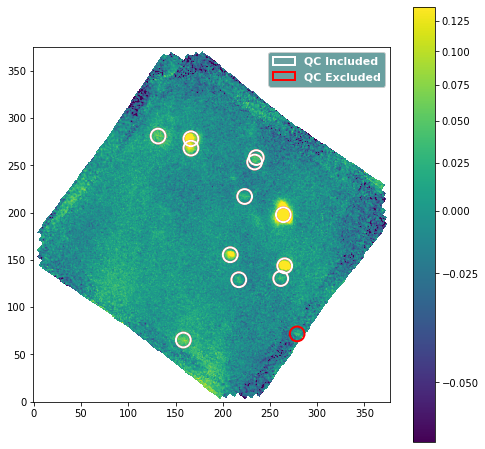

In [27]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

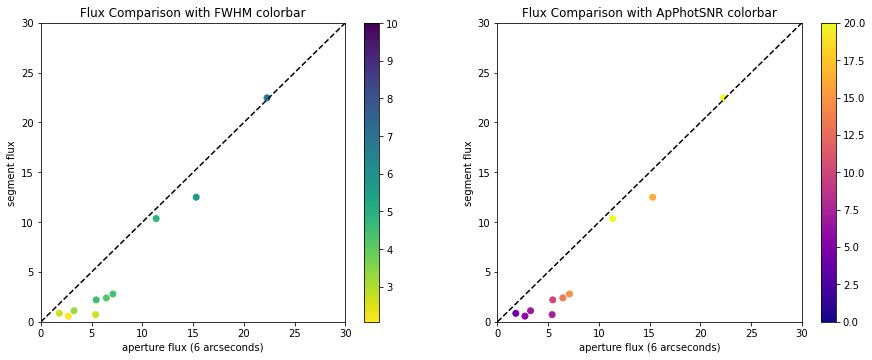

In [28]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

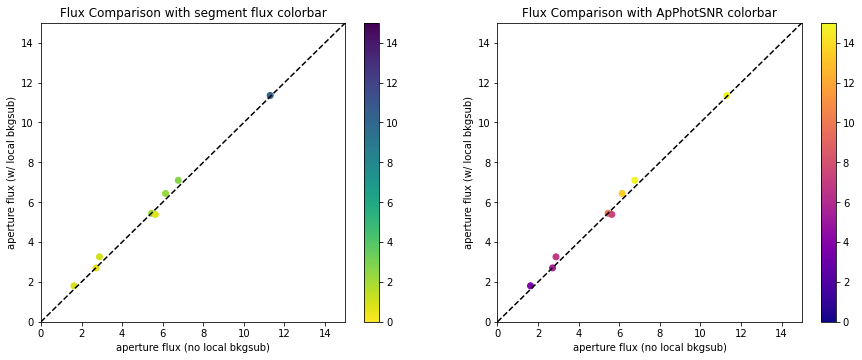

In [29]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [30]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)